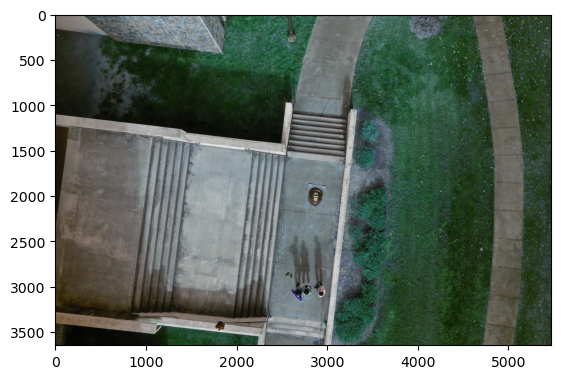

In [1]:
# Import required packages
import cv2
import pytesseract
from pytesseract import Output
import numpy as np
import os
import math
from matplotlib import pyplot as plt

# Mention the installed location of Tesseract-OCR in your system
def dist(x1, y1, x2, y2):
    return math.sqrt((x1-x2)*(x1-x2)+(y1-y2)*(y1-y2))
# Read image from which text needs to be extracted
img = cv2.imread("data/0i3/20m_good.jpeg")
# Preprocessing the image starts
plt.imshow(img)

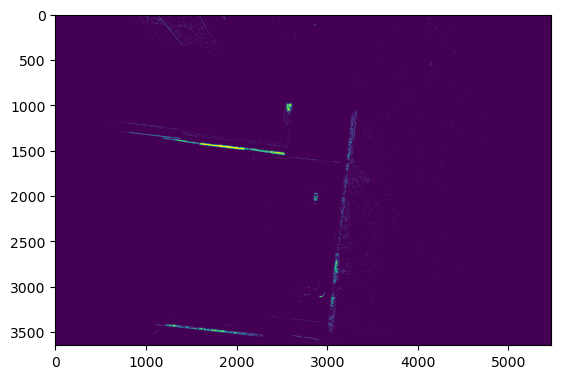

In [2]:
# Convert the image to gray scale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
cv2.imwrite("results/gray.jpg",gray)
#blurred = cv2.GaussianBlur(gray,(7,7),0)
# Performing OTSU threshold
ret, thresh1 = cv2.threshold(gray, 210, 255, cv2.THRESH_BINARY)
cv2.imwrite("results/thresh.jpg",thresh1)
plt.imshow(thresh1)

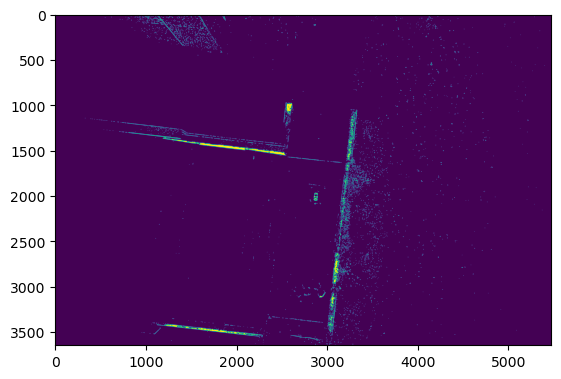

In [3]:
rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2,2))
 
# Applying dilation on the threshold image
dilation = cv2.dilate(thresh1, rect_kernel, iterations = 2)
cv2.imwrite('results/dilation.jpg',dilation)
plt.imshow(dilation)

In [4]:
contours, hierarchy = cv2.findContours(dilation, cv2.RETR_EXTERNAL,
                                                 cv2.CHAIN_APPROX_NONE)
im2 = img.copy()

In [5]:
count = 0 
lst = []
for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    count = count+1
    if w < 25 or h < 25 or w > 50 or h > 50:
        cv2.rectangle(dilation,(x,y), (x + w, y + h), (0, 0, 0), -1)
        continue
    # Drawing a rectangle on copied image
    # cv2.imshow('sample.jpg', im2)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()
    #print(f"{x} {y} {w} {h}")
    coords = [x, y, w, h]
    lst.append(coords)
    

    rect = cv2.rectangle(im2, (x, y), (x + w, y + h), (0, 255, 0), 2)
    cropped = thresh1[y:y + h, x:x + w]
    
    cv2.imwrite(f'cropped/cropped{count}.jpg',cropped)
    text = pytesseract.image_to_string(cropped)
     

In [7]:
cv2.imwrite('results/after.jpg',dilation)
lst.sort(key = lambda x:(x[0],x[1]))
# for i in lst:
#     print(i)
numC = len(lst)
win = []
for i in range(numC):
    for j in range(i+1,numC):
        for k in range(j+1, numC):
            if lst[j][1] > lst[i][1] and lst[k][1] < lst[j][1]:
                continue
            if lst[j][1] < lst[i][1] and lst[k][1] > lst[j][1]:
                continue
            centerI = (lst[i][0]+lst[i][2]/2,lst[i][1]+lst[i][3]/2)
            centerJ = (lst[j][0]+lst[j][2]/2,lst[j][1]+lst[j][3]/2)
            centerK = (lst[k][0]+lst[k][2]/2,lst[k][1]+lst[k][3]/2)
            dist1 = dist(centerI[0],centerI[1],centerJ[0],centerJ[1])
            dist2 = dist(centerK[0],centerK[1],centerJ[0],centerJ[1])
            if dist1 > 36 or dist2 > 36:
                continue
            win.append(lst[i])
            win.append(lst[j])
            win.append(lst[k])
cv2.imwrite('results/rects.jpg',img)
cv2.imwrite('results/rects2.jpg',im2)
for k in win:
    print(k)
slope = []
slope.append((win[1][1]-win[0][1])/(win[1][0]-win[0][0]))
slope.append((win[2][1]-win[1][1])/(win[2][0]-win[1][0]))
slope.append((win[2][1]-win[0][1])/(win[2][0]-win[0][0]))
avg = -(slope[2] + slope[1] + slope[0]) / 3
angle = math.degrees(math.atan(avg))
# print(avg)
print(angle)

rangeX1 = win[0][0]-10
rangeX2 = win[2][0]+10+win[2][2]
if ((win[2][0]+10+win[2][2])-(win[0][0]-10))%2 == 1:
    rangeX1 = rangeX1-1
rangeY1 = 0
ranegY2 = 0

if avg >= 0:
    rangeY2 = win[0][1]+10+win[0][3]
    rangeY1 = win[2][1]-10
    if ((win[0][1]+10+win[0][3])-(win[2][1]-10))%2 == 1:
        rangeY1 = rangeY1-1
else:
    rangeY2 = win[2][1]+10+win[2][3]
    rangeY1 = win[0][1]-10
    if ((win[2][1]+10+win[2][3])-(win[0][1]-10))%2 == 1:
        rangeY1 = rangeY1-1
        
print(f"{rangeX1} {rangeX2} {rangeY1} {rangeY2}")

corners = np.array([[2900,2067],[2910,1970],[2920, 1971],[2910,2068]])

cv2.fillPoly(dilation, pts = [corners], color =(255,255,255))

cv2.imwrite("results/withunder.jpg",dilation)


cropped_img = dilation[rangeY1:rangeY2,rangeX1:rangeX2]
h, w = cropped_img.shape
rad = math.radians(angle)
newW = int((w-h*math.tan(rad))/(math.cos(rad)*(1-math.tan(rad)*math.tan(rad))))+1
newH = int((w-newW*math.cos(rad))/math.sin(rad))+1
print(newW)
print(newH)
print(cropped_img.shape)
cv2.imwrite("results/cropped_img.jpg",cropped_img)

centerX = int((rangeX2-rangeX1)/2)
centerY = int((rangeY2-rangeY1)/2)
print((centerX,centerY))

# using cv2.getRotationMatrix2D() to get the rotation matrix
rotate_matrix = cv2.getRotationMatrix2D(center=(centerX,centerY), angle=-angle, scale=1)
# # rotate the image using cv2.warpAffine
rotated_image = cv2.warpAffine(src=cropped_img, M=rotate_matrix, dsize=(newW,newH))
cv2.imwrite('results/rotated.jpg',rotated_image)
text = pytesseract.image_to_string(rotated_image)
print(text)

[2855, 2030, 40, 27]
[2856, 2001, 42, 28]
[2861, 1971, 38, 26]
86.171788531525
2845 2909 1961 2067
103
58
(106, 64)
(32, 53)
i‘ el

